In [242]:
import pickle
import warnings
import random
import umap
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance, KDTree
from scipy import stats
from sklearn import decomposition
from IPython.display import display, Markdown

from torch.nn import functional as F

In [243]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 500

In [4]:
embeds, rows = [], []

titles = set()

for path in tqdm(glob('../data/clean-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            
            title = ' '.join(line.pop('tokens'))
            
            if title not in titles:
                embeds.append(line.pop('embedding'))
                rows.append(OrderedDict(title=title, **line))
                titles.add(title)

100%|██████████| 66/66 [00:25<00:00,  2.54it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['dailycaller.com', 'bloomberg.com', 'thehill.com',
       'huffingtonpost.com', 'dailykos.com', 'nytimes.com', 'cnn.com',
       'wsj.com', 'apnews.com', 'breitbart.com', 'foxnews.com',
       'washingtonpost.com', 'buzzfeed.com'], dtype=object)

In [8]:
embeds.shape

(642151, 512)

In [9]:
df['p_true'] = df.apply(lambda r: r[f'p_{r.label}'], axis=1)

In [127]:
df['count_rank'] = df.groupby('label')['count'].rank(method='min', pct=True)

In [155]:
df['logc'] = np.log10(df['count'])

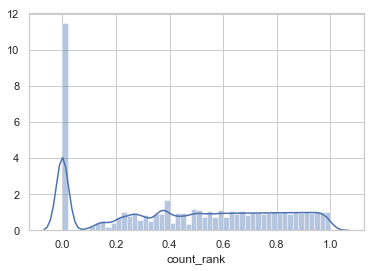

In [128]:
sns.distplot(df.count_rank)

In [222]:
def pt_rank_reg(dfp, n=10000):
    
    sns.jointplot(x='p_breitbart.com', y='logc', data=dfp, size=3, s=0.1)
    plt.show()
    
    x = list(dfp.p_true)
    y = list(dfp.logc)
    
    c, p = stats.kendalltau(x, y)
    
    samples = []
    for _ in tqdm(range(100)):
        random.shuffle(y)
        c_, _ = stats.kendalltau(x, y)
        samples.append(c_)
        
    dfp['logc'] = y
    sns.jointplot(x='p_nytimes.com', y='logc', data=dfp, size=3, s=0.1)
    plt.show()
    
    plt.figure(figsize=(3,2))
    sns.distplot(samples)
    plt.axvline(c)
    plt.show()
    
    print(c, p)
    print((c - np.mean(samples)) / np.std(samples))
    print('\n\n')

dailycaller.com 9851


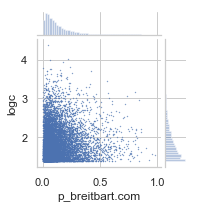

100%|██████████| 100/100 [00:00<00:00, 101.75it/s]


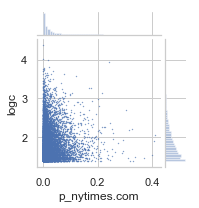

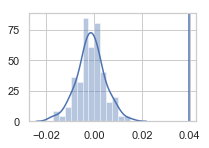

0.039611703029513466 4.5081004792956986e-09
7.065743564172347



bloomberg.com 9596


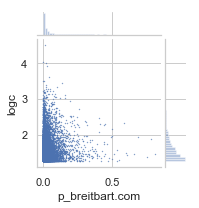

100%|██████████| 100/100 [00:01<00:00, 98.45it/s]


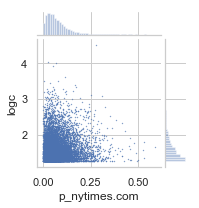

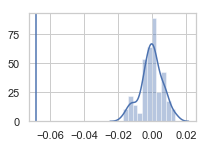

-0.0682728857518968 3.41541763855197e-23
-10.429725549370254



thehill.com 9900


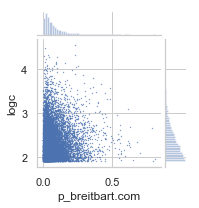

100%|██████████| 100/100 [00:01<00:00, 93.40it/s]


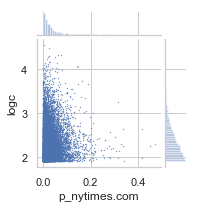

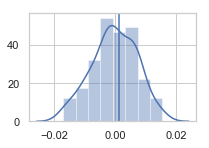

0.0013403090528221872 0.8417248456203278
0.21976182261970625



huffingtonpost.com 9715


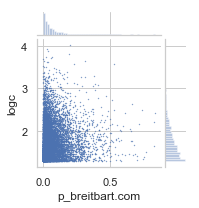

100%|██████████| 100/100 [00:00<00:00, 103.94it/s]


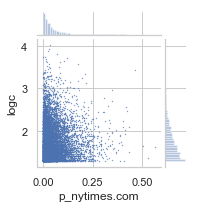

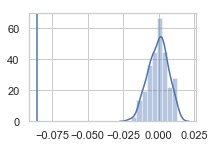

-0.08570740660279492 2.5398270526768573e-36
-12.603845718403596



dailykos.com 9891


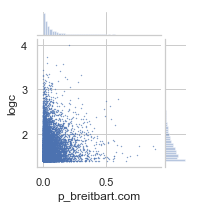

100%|██████████| 100/100 [00:01<00:00, 96.47it/s]


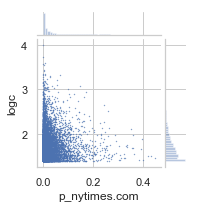

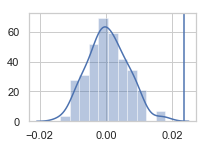

0.023502370903812943 0.0005084348417500661
3.8658343466813823



nytimes.com 9610


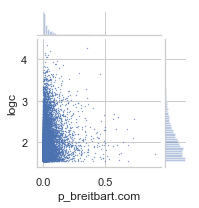

100%|██████████| 100/100 [00:00<00:00, 105.39it/s]


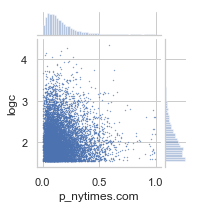

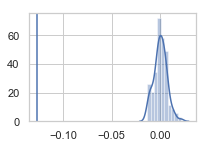

-0.1268464202650642 3.793133872772533e-77
-19.151650641301888



cnn.com 9949


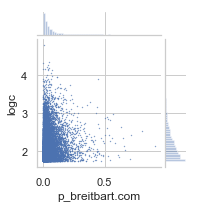

100%|██████████| 100/100 [00:01<00:00, 96.65it/s]


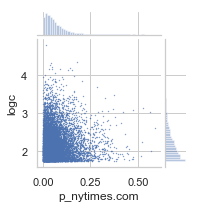

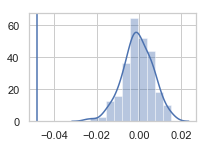

-0.048403507593277204 5.117011680534309e-13
-6.781703498838156



wsj.com 10003


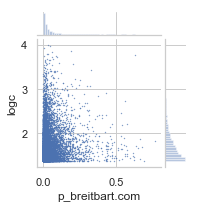

100%|██████████| 100/100 [00:01<00:00, 96.76it/s]


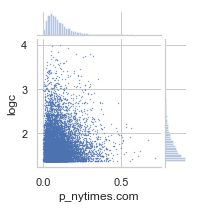

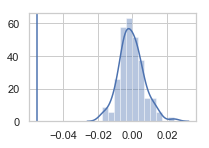

-0.05530193130645409 1.9310708447030167e-16
-7.652964871039316



apnews.com 8868


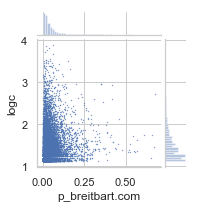

100%|██████████| 100/100 [00:00<00:00, 114.56it/s]


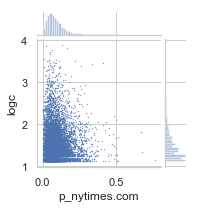

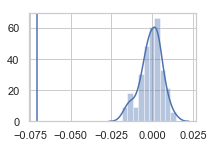

-0.0708581839254911 4.8661891274907965e-23
-10.529962576690808



breitbart.com 9815


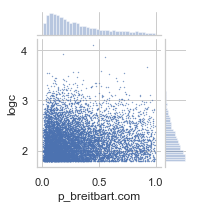

100%|██████████| 100/100 [00:00<00:00, 100.16it/s]


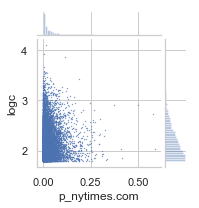

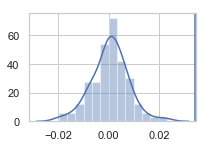

0.03426372694657814 3.800431794707633e-07
4.630546877071804



foxnews.com 9450


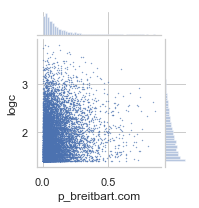

100%|██████████| 100/100 [00:00<00:00, 102.77it/s]


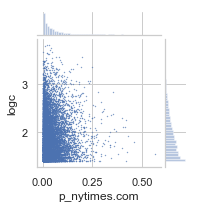

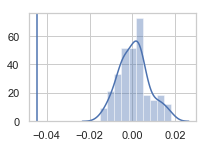

-0.04460337449849736 9.449943543730632e-11
-6.494334908648909



washingtonpost.com 9632


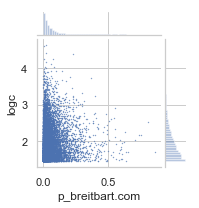

100%|██████████| 100/100 [00:00<00:00, 102.17it/s]


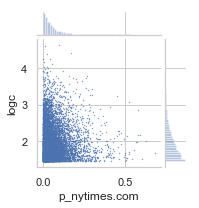

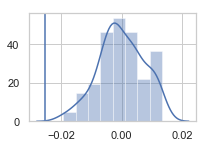

-0.025602595483797 0.00017479876578399754
-3.432717326941929



buzzfeed.com 9981


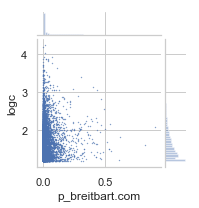

100%|██████████| 100/100 [00:00<00:00, 100.20it/s]


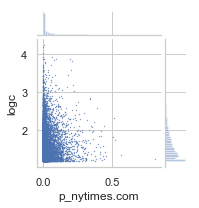

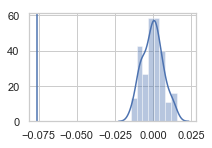

-0.07628298875244284 1.0260330858159993e-29
-11.36566450388576





In [223]:
for d in df.label.unique():
    
    dfp = df[(df.count_rank>0.8)&(df.label==d)]
    print(d, len(dfp))
    pt_rank_reg(dfp, 10000)

In [224]:
nyt = df[df.label=='nytimes.com']

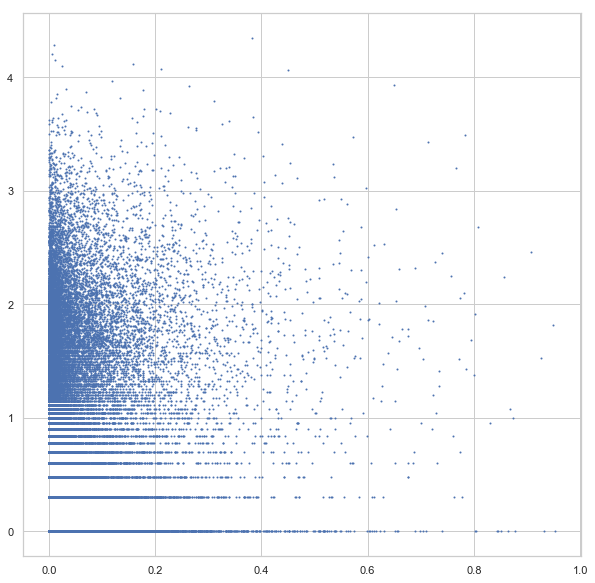

In [231]:
plt.figure(figsize=(10,10))
plt.scatter(nyt['p_dailykos.com'], nyt.logc, s=1)

In [235]:
nytt = nyt.sort_values('count', ascending=False).head(1000)

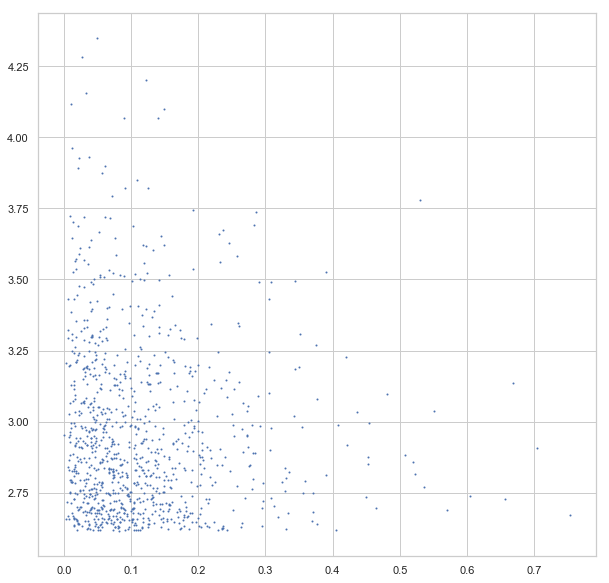

In [241]:
plt.figure(figsize=(10,10))
plt.scatter(nytt['p_nytimes.com'], nytt.logc, s=1)